In [ ]:
import librosa
import numpy as np

### Final attempt at data preproccesing

In [ ]:
import librosa
import numpy as np

def extract_features(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Extract features
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    root_mean_sq = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    harmony, percussion = librosa.effects.hpss(y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)

    print(np.shape(mfccs))


    feature_vector = [np.mean(chromagram), np.var(chromagram), np.mean(root_mean_sq), np.var(root_mean_sq),
                      np.mean(spectral_centroid), np.var(spectral_centroid), np.mean(spectral_bandwidth),np.var(spectral_bandwidth),
                      np.mean(rolloff), np.var(rolloff), np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
                      np.mean(harmony), np.var(harmony), np.mean(percussion), np.var(percussion), tempo]

    # Add mean and variance of MFCCs
    for i in range(0, 20):

        feature_vector.append(np.mean(mfccs[i]))
        feature_vector.append(np.var(mfccs[i]))

    return feature_vector


In [ ]:
print(extract_features("train000.wav"))

(20, 1293)
[0.49693632, 0.074088484, 0.21548757, 0.0045074425, 2327.3042883656067, 326509.7898285401, 2516.6762247035786, 78388.97811704749, 4929.812855731583, 1209579.618561012, 0.09544520072022429, 0.0026555356772195323, -3.3191096e-05, 0.019695848, 0.00022804442, 0.014144431, 107.666015625, -30.302328, 2302.5728, 88.46916, 507.815, -6.565683, 283.72113, 32.79242, 96.51369, 8.502236, 61.604366, 8.387787, 58.229748, 2.0520325, 77.62554, 6.863294, 57.416336, 3.5781379, 48.508255, 2.7206445, 45.872013, 1.2915944, 40.098003, 3.2918952, 36.68938, 1.5701153, 26.20597, 2.377863, 26.768229, 2.5288734, 26.752012, 1.1006651, 22.222546, -1.5776114, 23.956354, -0.2624535, 30.195358, 0.1183315, 25.60868, 0.42553532, 22.239328]


###Audio processing 1. generate more audio 2. Perform PCA

In [ ]:
filenames_training = []
for i in range(10):
  filenames_training.append('train00{}.wav'.format(i))
for i in range(10, 100):
  filenames_training.append('train0{}.wav'.format(i))
for i in range(100, 800):
  filenames_training.append('train{}.wav'.format(i))

In [ ]:
filenames_testing = []
for i in range(10):
  filenames_testing.append('test00{}.wav'.format(i))
for i in range(10, 100):
  filenames_testing.append('test0{}.wav'.format(i))
for i in range(100, 200):
  filenames_testing.append('test{}.wav'.format(i))

In [ ]:
import math

num_mfcc=13
n_fft=2048
hop_length=512
num_segments=5
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

In [ ]:
def get_mfccs(filename):
  #extract the signals from the wav files
  signal, sample_rate = librosa.load(filename, sr=SAMPLE_RATE)
  mfcc_list = []
  #break up the signals into more usable pieces
  for piece_idx in range(num_segments):

    #gets the start and end points for the signal piece
    start = samples_per_segment * piece_idx
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T
    mfcc_list.append(mfcc)
    flattened_list = [item for sublist in mfcc_list for item in sublist]
    flattened_array = np.array(flattened_list)
    feature_vector = flattened_array.flatten()
    return feature_vector

In [ ]:
#X1 will be the matrix made of training audio. This matrix will be split into training and testing parts
#X2 will be the matrix made of testing audio

X1 = []
X2 = []

# for file in filenames_training:
#   X1.append(get_mfccs(file))

# for file in filenames_testing:
#   X2.append(get_mfccs(file))

for file in filenames_training:
  X1.append(extract_features(file))

for file in filenames_testing:
  X2.append(extract_features(file))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X1 = StandardScaler().fit_transform(X1)
pca = PCA(n_components=10)
X1PCA = pca.fit_transform(X1)

In [ ]:
X2 = StandardScaler().fit_transform(X2)
pca = PCA(n_components=10)
X2PCA = pca.fit_transform(X2)

In [ ]:
import csv

#making the label vector
labels_dict = {}

with open('train.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        labels_dict[row[0]] = row[1]

In [ ]:
str_to_num = {}
num_to_str = {}
for i, str in enumerate(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']):
  str_to_num[str] = i
  num_to_str[i] = str

In [ ]:
y = np.zeros((800, 1))
for i, file in enumerate(filenames_training):
    y[i] = str_to_num[labels_dict[file]]
y = y.flatten()

In [ ]:
#Saving X1PCA and X2PCA
file_name = 'X1'
X1 = []
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(X1)

file_name = 'X2'
X2 = []
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(X2)

In [ ]:
#Loading X1PCA and X2PCA
import csv

X1 = []

with open('X1', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        num_row = [float(x) for x in row]
        X1.append(num_row)
# X2 = []

# with open('X2', 'r') as file:
#     reader = csv.reader(file)
#     for row in reader:
#         num_row = [float(x) for x in row]
#         X2.append(num_row)

In [ ]:
import csv
import numpy as np

Xmfcc = []

with open('MFCC&DeltaMFCC_X', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        num_row = [float(x) for x in row]
        Xmfcc.append(num_row)

In [ ]:
print(np.shape(Xmfcc))

(800, 16770)


### Model 1: Pytorch Neural Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
class Model(nn.Module):
  #inut layer (13 features)
  def __init__(self, input_size=57, h1=512, h2=256, h3=64, output_size=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        # self.fc4 = nn.Linear(h3, output_size)
        self.dropout = nn.Dropout(p=0.3)  # Define dropout layer
        self.softmax = nn.Softmax(dim=1)  # Define softmax layer

  def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = self.dropout(x)

      x = torch.relu(self.fc2(x))
      x = self.dropout(x)

      x = torch.relu(self.fc3(x))
      x = self.dropout(x)  # Apply dropout
      # x = self.fc4(x)
      x = self.softmax(x)  # Apply softmax
      return x

In [ ]:
model = Model()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=.2)

In [ ]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [ ]:
y_train = torch.FloatTensor(y_train).long()
y_test = torch.FloatTensor(y_test).long()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
epochs = 5000
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred, y_train)
  losses.append(loss.detach().numpy())

  if i % 100 == 0:
    print(f'Epoch: {i} and loss: {loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 and loss: 4.182253837585449


KeyboardInterrupt: 

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
with torch.no_grad():
  y_eval = model.forward(X_test)
  loss = criterion(y_eval, y_test)

In [ ]:
loss

### Tensorflow NN

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(57,)))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 57)                0         
                                                                 
 dense (Dense)               (None, 512)               29696     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xmfcc, y, test_size=.2)

In [ ]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
# compile the model
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_test,y_test),
                 epochs = 100,
                 batch_size = 32)

Epoch 1/100
20/20 [==============================] - 9s 176ms/step - loss: 2.3682 - accuracy: 0.2109 - val_loss: 4.3815 - val_accuracy: 0.1625
Epoch 2/100
20/20 [==============================] - 3s 163ms/step - loss: 1.7255 - accuracy: 0.3891 - val_loss: 2.5972 - val_accuracy: 0.2000
Epoch 3/100
20/20 [==============================] - 5s 263ms/step - loss: 1.4064 - accuracy: 0.5234 - val_loss: 2.5388 - val_accuracy: 0.1875
Epoch 4/100
20/20 [==============================] - 3s 163ms/step - loss: 1.1691 - accuracy: 0.6359 - val_loss: 1.8499 - val_accuracy: 0.3375
Epoch 5/100
20/20 [==============================] - 3s 160ms/step - loss: 0.9977 - accuracy: 0.6734 - val_loss: 1.7337 - val_accuracy: 0.3938
Epoch 6/100
20/20 [==============================] - 3s 161ms/step - loss: 0.8455 - accuracy: 0.7641 - val_loss: 1.6397 - val_accuracy: 0.4375
Epoch 7/100
20/20 [==============================] - 6s 294ms/step - loss: 0.6892 - accuracy: 0.8391 - val_loss: 1.6043 - val_accuracy: 0.4375

In [ ]:
model.save("my second neural network")

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

5/5 [==============================] - 0s 7ms/step - loss: 767.1747 - accuracy: 0.4563
Test accuracy: 0.45625001192092896


In [ ]:
tf.keras.models.load_model('my second neural network')
X2 = tf.convert_to_tensor(X2, dtype=tf.float32)
predictions = model.predict(X2)

OSError: No file or directory found at my second neural network

In [ ]:
true_y = []
for row in predictions:
  true_y.append(num_to_str[np.argmax(row)])

### Ensemble learning

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.6 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import catboost as cb
from xgboost import XGBClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
cbc = cb.CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)

for clf in (rf, cbc, xgb):
	clf.fit(X_train, y_train)
	preds = clf.predict(X_test)
	print(clf.__class__.__name__,accuracy_score(y_test, preds))

RandomForestClassifier 0.76875
CatBoostClassifier 0.79375
XGBClassifier 0.775


In [ ]:
predictions = clf.predict(X2)

In [ ]:
true_y = []
for num in predictions:
  true_y.append(num_to_str[num])

### making the CSV :)

In [ ]:
data = [['ID', 'Genre']]
for i in range(10):
  data.append(['test00{}.wav'.format(i), true_y[i]])
for i in range(10, 100):
  data.append(['test0{}.wav'.format(i), true_y[i]])
for i in range(100, 200):
  data.append(['test{}.wav'.format(i), true_y[i]])

  file_name = 'TF_nn_more_nodes.csv'

with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

### SVC

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=.2)

In [ ]:
#radial basis
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='scale'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [ ]:
accuracy = 0
train_accuracy = 0

for i in range(len(y_test)):
    if clf.predict([X_test[i]])[0] == y_test[i]:
        accuracy += 1

for i in range(len(y_train)):
    if clf.predict([X_train[i]])[0] == y_train[i]:
        train_accuracy += 1

final_accuracy = accuracy/len(y_test)
final_accuracy_train = train_accuracy/len(y_train)

print('accuracy', final_accuracy)
print('train accuracy', final_accuracy_train)

accuracy 0.70625
train accuracy 0.884375


In [ ]:
#linear
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', gamma='scale'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [ ]:
accuracy = 0
train_accuracy = 0

for i in range(len(y_test)):
    if clf.predict([X_test[i]])[0] == y_test[i]:
        accuracy += 1

for i in range(len(y_train)):
    if clf.predict([X_train[i]])[0] == y_train[i]:
        train_accuracy += 1

final_accuracy = accuracy/len(y_test)
final_accuracy_train = train_accuracy/len(y_train)

print('accuracy', final_accuracy)
print('train accuracy', final_accuracy_train)

accuracy 0.69375
train accuracy 0.9890625


In [ ]:
#poly
clf = make_pipeline(StandardScaler(), SVC(kernel='poly', gamma='scale'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly'))])

In [ ]:
accuracy = 0
train_accuracy = 0

for i in range(len(y_test)):
    if clf.predict([X_test[i]])[0] == y_test[i]:
        accuracy += 1

for i in range(len(y_train)):
    if clf.predict([X_train[i]])[0] == y_train[i]:
        train_accuracy += 1

final_accuracy = accuracy/len(y_test)
final_accuracy_train = train_accuracy/len(y_train)

print('accuracy', final_accuracy)
print('train accuracy', final_accuracy_train)

accuracy 0.60625
train accuracy 0.7484375


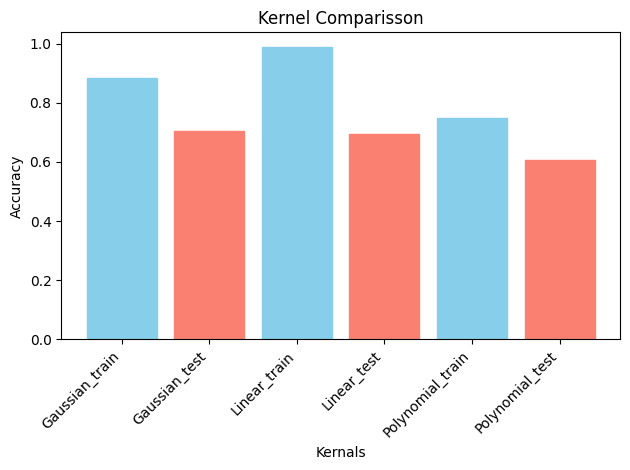

In [1]:
#make graph of model accuracy
import matplotlib.pyplot as plt

labels = ['Gaussian_train','Gaussian_test', 'Linear_train','Linear_test', 'Polynomial_train', 'Polynomial_test']
accuracies = [0.884375, 0.70625, 0.9890625, 0.69375, 0.7484375, 0.60625]

bars = plt.bar(labels, accuracies)

for i in range(len(bars)):
    if i % 2 == 0:  # Check if the index is even
        bars[i].set_color('skyblue')  # Set color for even-indexed bars
    else:
        bars[i].set_color('salmon')  # Set color for odd-indexed bars

plt.xlabel('Kernals')
plt.ylabel('Accuracy')
plt.title('Kernel Comparisson')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
